This is a full description of every available field in the LPathData /local_path topic message.

collect a rosbag using `ros2 bag record -o bag_file_name --topics /local_path`


```
Path global_path: 
    HelperLatLon[] waypoints: HelperLatLon: 
        float32 latitude 
        float32 longitude 

Path local_path: 
    HelperLatLon[] waypoints: 
        HelperLatLon: 
            float32 latitude 
            float32 longitude 

GPS gps: 
    HelperLatLon lat_lon: 
        float32 latitude 
        float32 longitude 
    HelperSpeed speed: 
        float32 speed 
    HelperHeading heading: 
        float32 heading 

WindSensor filtered_wind_sensor: 
    HelperSpeed speed: 
        float32 speed 
    int16 direction 

AISShips ais_ships: 
    HelperAISShip[] ships: 
        HelperAISShip:
            uint32 id 
            HelperLatLon lat_lon: 
                float32 latitude 
                float32 longitude 
            HelperHeading cog: 
                float32 heading 
            HelperSpeed sog: 
                float32 speed 
            HelperROT rot: 
                int8 rot 
            HelperDimension width: 
                float32 dimension 
            HelperDimension length: 
                float32 dimension 

HelperObstacle[] obstacles: 
    HelperObstacle: 
        HelperLatLon[] points 
            HelperLatLon: 
                float32 latitude 
                float32 longitude 
        string obstacle_type 

DesiredHeading desired_heading: 
    HelperHeading heading: 
        float32 heading 
        uint8 steering
```

In [4]:
import pandas as pd
import rosbag2_py
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

import local_pathfinding.coord_systems as cs
import local_pathfinding.wind_coord_systems as wcs

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# every SAMPLE_RATE'th datapoint will actually be drawn on the plot
SAMPLE_RATE = 6

In [5]:
bag_path = "rosbag2_2026_01_17-23_44_31/rosbag2_2026_01_17-23_44_31_0.db3"
topic_name = "/local_path"
msg_type = "custom_interfaces/msg/LPathData"


reader = rosbag2_py.SequentialReader()
storage_options = rosbag2_py.StorageOptions(uri=bag_path, storage_id="sqlite3")
converter_options = rosbag2_py.ConverterOptions(
    input_serialization_format="cdr", output_serialization_format="cdr"
)

reader.open(storage_options, converter_options)
msg_class = get_message(msg_type)

rows = []

while reader.has_next():
    topic, data, t = reader.read_next()
    if topic != topic_name:
        continue

    msg = deserialize_message(data, msg_class)

    rows.append(
        {
            "timestamp": t,
            "global_path": msg.global_path,
            "local_path": msg.local_path,
            "gps": msg.gps,
            "filtered_wind_sensor": msg.filtered_wind_sensor,
            "ais_ships": msg.ais_ships,
            "obstacles": msg.obstacles,
            "desired_heading": msg.desired_heading,
        }
    )

df = pd.DataFrame(rows)

[ERROR] [1769908591.023398941] [rosbag2_storage:134]: Could not open 'rosbag2_2026_01_17-23_44_31/rosbag2_2026_01_17-23_44_31_0.db3' with 'sqlite3'. Error: Failed to read from bag: File 'rosbag2_2026_01_17-23_44_31/rosbag2_2026_01_17-23_44_31_0.db3' does not exist!
[ERROR] [1769908591.023424909] [rosbag2_storage:198]: Could not load/open plugin with storage id 'sqlite3'


RuntimeError: No storage could be initialized from the inputs.

In [78]:
df.head()

,timestamp,global_path,local_path,gps,filtered_wind_sensor,ais_ships,obstacles,desired_heading
0,1768717514695167174,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
1,1768717515772396433,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
2,1768717516838999675,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
3,1768717517910918009,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...
4,1768717518987746454,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.Path(waypoints=[custom_i...,custom_interfaces.msg.GPS(lat_lon=custom_inter...,custom_interfaces.msg.WindSensor(speed=custom_...,custom_interfaces.msg.AISShips(ships=[custom_i...,[custom_interfaces.msg.HelperObstacle(points=[...,custom_interfaces.msg.DesiredHeading(heading=c...


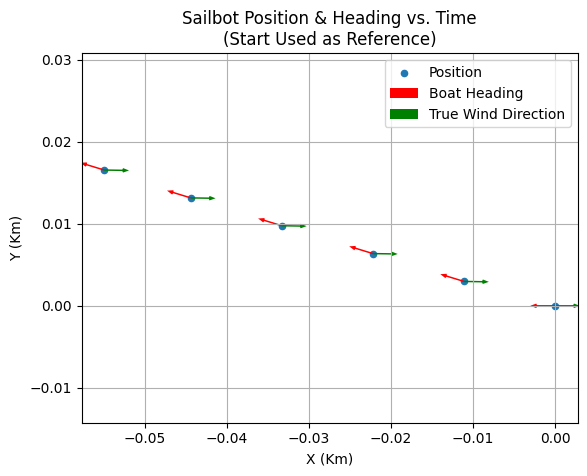

In [14]:
# position over time
positions_lat_lon = []
headings_deg = []
for data_point in df["gps"]:
    positions_lat_lon.append(data_point.lat_lon)
    headings_deg.append(data_point.heading.heading)

reference_point = positions_lat_lon[0]
positions_xy_km = cs.latlon_list_to_xy_list(reference_point, positions_lat_lon)

headings_cartesian_deg = [90 - heading_deg for heading_deg in headings_deg]
x_km = [xy.x for xy in positions_xy_km]
y_km = [xy.y for xy in positions_xy_km]

# Use every 3rd data point
x_km_sparse = x_km[::SAMPLE_RATE]
y_km_sparse = y_km[::SAMPLE_RATE]
headings_sparse = headings_cartesian_deg[::SAMPLE_RATE]

plt.scatter(x_km_sparse, y_km_sparse, s=20, label="Position")

# Add arrows for heading direction
# Convert headings to radians
heading_rads = np.radians(headings_sparse)

# Calculate arrow components
dx = np.cos(heading_rads)
dy = np.sin(heading_rads)

# Plot arrows with quiver (auto-scales nicely)
plt.quiver(
    x_km_sparse,
    y_km_sparse,
    dx,
    dy,
    color="red",
    scale=20,
    width=0.003,
    headwidth=3,
    headlength=4,
    label="Boat Heading",
)

# get the true wind directions
boat_headings_deg = []
boat_speeds_kmph = []
for data_point in df["gps"]:
    boat_headings_deg.append(data_point.heading.heading)
    boat_speeds_kmph.append(data_point.speed.speed)

aw_directions_deg = []
aw_speeds_kmph = []
for data_point in df["filtered_wind_sensor"]:
    aw_directions_deg.append(data_point.direction)
    aw_speeds_kmph.append(data_point.speed.speed)

aw_directions_degrees_global_coords = [
    wcs.boat_to_global_coordinate(boat_hding_deg, aw_dir_deg)
    for boat_hding_deg, aw_dir_deg in zip(boat_headings_deg, aw_directions_deg)
]

tw_directions_rad, tw_speeds_kmph = zip(
    *[
        wcs.get_true_wind(
            aw_dir_deg_global_coords,
            aw_speed_kmph,
            boat_hding_deg,
            boat_speed_kmph,
        )
        for aw_dir_deg_global_coords, aw_speed_kmph, boat_hding_deg, boat_speed_kmph in zip(
            aw_directions_degrees_global_coords,
            aw_speeds_kmph,
            boat_headings_deg,
            boat_speeds_kmph,
        )
    ]
)

tw_directions_deg_cartesian = [90 - np.degrees(a) for a in tw_directions_rad][::SAMPLE_RATE]

# Add arrows for true wind direction
# Convert headings to radians
heading_rads = np.radians([tw_directions_deg_cartesian[i] for i in range(len(x_km_sparse))])

# Calculate arrow components
dx = np.cos(heading_rads)
dy = np.sin(heading_rads)

# Plot arrows with quiver (auto-scales nicely)
plt.quiver(
    x_km_sparse,
    y_km_sparse,
    dx,
    dy,
    color="green",
    scale=20,
    width=0.003,
    headwidth=3,
    headlength=4,
    label="True Wind Direction",
)

plt.title("Sailbot Position & Heading vs. Time\n(Start Used as Reference)")
plt.xlabel("X (Km)")
plt.ylabel("Y (Km)")
plt.grid(visible=True)
plt.axis("equal")
plt.legend()
plt.show()

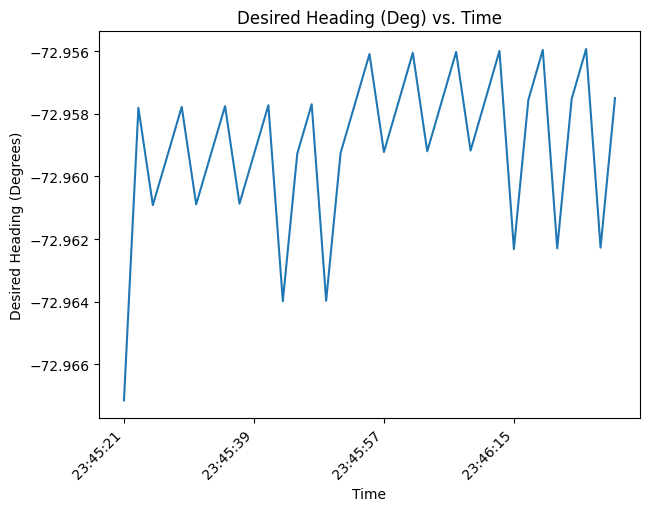

In [10]:
# desired heading vs time
time = [t for t in df["timestamp"]]
timestamps = [datetime.fromtimestamp(t / 1_000_000_000).strftime("%H:%M:%S") for t in time]
d_headings_deg = [data_point.heading.heading for data_point in df["desired_heading"]]

plt.plot(timestamps, d_headings_deg)

# Show only every 3rd timestamp label at an angle
plt.xticks(
    range(0, len(timestamps), SAMPLE_RATE),
    [timestamps[i] for i in range(0, len(timestamps), SAMPLE_RATE)],
    rotation=45,
    ha="right",
)

plt.tight_layout()
plt.title("Desired Heading (Deg) vs. Time")
plt.ylabel("Desired Heading (Degrees)")
plt.xlabel("Time")
plt.show()

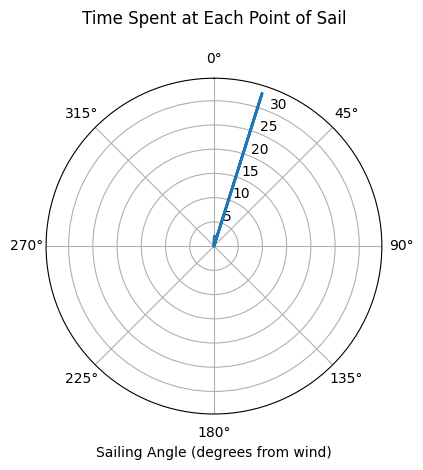

In [15]:
# Sailing Angle Distribution
boat_headings_deg = []
boat_speeds_kmph = []
for data_point in df["gps"]:
    boat_headings_deg.append(data_point.heading.heading)
    boat_speeds_kmph.append(data_point.speed.speed)

aw_directions_deg = []
aw_speeds_kmph = []
for data_point in df["filtered_wind_sensor"]:
    aw_directions_deg.append(data_point.direction)
    aw_speeds_kmph.append(data_point.speed.speed)

aw_directions_degrees_global_coords = [
    wcs.boat_to_global_coordinate(boat_hding_deg, aw_dir_deg)
    for boat_hding_deg, aw_dir_deg in zip(boat_headings_deg, aw_directions_deg)
]

tw_directions_rad, tw_speeds_kmph = zip(
    *[
        wcs.get_true_wind(
            aw_dir_deg_global_coords,
            aw_speed_kmph,
            boat_hding_deg,
            boat_speed_kmph,
        )
        for aw_dir_deg_global_coords, aw_speed_kmph, boat_hding_deg, boat_speed_kmph in zip(
            aw_directions_degrees_global_coords,
            aw_speeds_kmph,
            boat_headings_deg,
            boat_speeds_kmph,
        )
    ]
)

tw_directions_deg = [np.degrees(a) for a in tw_directions_rad]
sailing_angles_deg = [
    abs(-tw_dir - boat_hding) for tw_dir, boat_hding in zip(tw_directions_deg, boat_headings_deg)
]

# Create histogram bins
num_bins = 36  # 5-degree bins for 180 degrees
counts, bin_edges = np.histogram(sailing_angles_deg, bins=num_bins, range=(0, 180))

# Convert bin edges to radians for polar plot
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
theta = np.radians(bin_centers)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

# Plot as continuous curve
# Close the curve by appending first value
theta_closed = np.append(theta, theta[0])
counts_closed = np.append(counts, counts[0])

ax.plot(theta_closed, counts_closed, linewidth=2)
ax.fill(theta_closed, counts_closed, alpha=0.3)

# Set 0 degrees at top
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)  # Clockwise

# Labels
ax.set_title("Time Spent at Each Point of Sail", pad=20)
ax.set_xlabel("Sailing Angle (degrees from wind)")

plt.tight_layout()
plt.show()